<a href="https://colab.research.google.com/github/TomFrederik/lucent/blob/dev/notebooks/first_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<img src="https://raw.githubusercontent.com/greentfrapp/lucent/master/images/lucent_header.jpg" width="600"></img>

# Lucent Tutorial

A Colab notebook following the spirit of Lucid's notebooks.



## Install, Import, Load Model

In [2]:
!pip install --quiet git+https://github.com/TomFrederik/lucent.git


     |████████████████████████████████| 225 kB 17.4 MB/s 


Let's import torch and lucent, and set the device variable. 


In [3]:
import torch
from lucent.optvis import render, param, transform, objectives

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

We will now load the InceptionV1 model (also known as GoogLeNet), but you could also use any other image-based network here.
We will send it to the device and set it to eval mode to avoid gradient tracking and unnecessary computations and disable any potential dropouts.


In [4]:
from torchvision.models import googlenet # import InceptionV1 aka GoogLeNet

model = googlenet(pretrained=True)
_ = model.to(device).eval() # the underscore prevents printing the model if it's the last line in a ipynb cell

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Similar to [Lucid](https://github.com/tensorflow/lucid/), this tutorial will be focused on the same InceptionV1 model, also known as GoogLeNet.

Check out the original GoogLeNet paper [here](https://research.google.com/pubs/archive/43022.pdf).

[Distill](https://distill.pub) also has a fascinating [article](https://distill.pub/2017/feature-visualization/) on this topic that includes visualizations of all the InceptionV1 neurons.


## Feature visualization

Now that we have our model we will start of with the bread and butter of mechanistic interpretability: **feature visualization**.

The core idea is to optimize the input image to the network such that a certain neuron or channel gets maximally excited. 

**Question**: How would that help with understanding what network is doing? How could that give us misleading results?

<details>
<summary><a>Answer</a></summary>

Optimizing the input to maximally excite a neuron produces a sort of super-stimulus.

However, this method usually produces images that are very different from the data distribution. We might be worried that it picks up on spurious correlations instead of reflecting what the neuron does when it encounters real images.
</details>

In order to perform feature visualization we have to specify an objective function with respect to which we will optimize the input image.

The default of ``render.render_vis`` is to assume you gave it a description of the form 'layer:channel' and want it to optimize the whole feature map of the channel.

`render_vis` has a few nice defaults so we can get started quickly!

For example, if we want to optimize the input for the 476th channel in layer ``inception4a``:

100%|██████████| 512/512 [00:10<00:00, 48.08it/s]



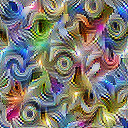

In [5]:
# list of images has one element in this case
list_of_images = render.render_vis(model, "inception4a:476", show_inline=True)

Now, what if you don't know the names of all the layers in your network? Lucent has you covered, with its ``get_model_layers`` method:

In [6]:
from lucent.model_utils import get_model_layers

layer_names, dependency_graph = get_model_layers(model)
    
print(layer_names)


['conv1', 'conv1->conv', 'conv2', 'conv2->conv', 'conv3', 'conv3->conv', 'inception3a', 'inception3a->branch1', 'inception3a->branch1->conv', 'inception3a->branch2->0', 'inception3a->branch2->0->conv', 'inception3a->branch2->1', 'inception3a->branch2->1->conv', 'inception3a->branch3->0', 'inception3a->branch3->0->conv', 'inception3a->branch3->1', 'inception3a->branch3->1->conv', 'inception3a->branch4->1', 'inception3a->branch4->1->conv', 'inception3b', 'inception3b->branch1', 'inception3b->branch1->conv', 'inception3b->branch2->0', 'inception3b->branch2->0->conv', 'inception3b->branch2->1', 'inception3b->branch2->1->conv', 'inception3b->branch3->0', 'inception3b->branch3->0->conv', 'inception3b->branch3->1', 'inception3b->branch3->1->conv', 'inception3b->branch4->1', 'inception3b->branch4->1->conv', 'inception4a', 'inception4a->branch1', 'inception4a->branch1->conv', 'inception4a->branch2->0', 'inception4a->branch2->0->conv', 'inception4a->branch2->1', 'inception4a->branch2->1->conv', 

``layer_names`` is a list of *all* layer names, including nested ones. Nesting is denoted via ``layer->sublayer``. 
``dependency_graph`` makes this parent-child relation more explicit by storing all layers in a nested ``OrderedDict``.

At the present moment we haven't implemented a method to detect how many channels each layer has, but that's upcoming.

## Fiddling with the Knobs

Just like Lucid, Lucent splits visualizations into *objectives*, *parameterizations* and *transforms*. To quote from Lucid's tutorial:

* **Objectives** -- What do you want the model to visualize?
* **Parameterizations** -- How do you describe the image?
* **Transforms** -- What transformations do you want your visualization to be robust to?

## Objectives

What loss function do we want to minimize?

Or from another point of view, what part of the model do we want to understand?

In essence, we are trying to generate an image that causes a particular neuron or filter to activate strongly. 
The objective allows us to select a specific neuron, channel or a mix! The default is the channel objective. 

You can also explicitly state the objective instead of providing an identifying string:

100%|██████████| 512/512 [00:09<00:00, 52.45it/s]



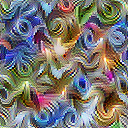

In [7]:
# This code snippet is equivalent to what we did above
obj = objectives.channel('inception4a', 476)
list_of_images = render.render_vis(model, obj, show_inline=True)

There are a few predefined objective functions, such as ``channel``, ``neuron`` and ``direction``. Learn more about them in :ref:`Native Objectives`. 
You can also define your own objective, which we will explain in :ref:`custom_objectives`. 

In principle, the objective can be any differentiable function that takes as input the feature map of the entire model
and returns some loss value. For example, by using the ``channel`` objective, we specify that we want to minimize the 
negative, mean activation of a particular layer's activation at a particular channel.

Objectives can be combined via all the standard arithmetic operators (+, -, *, /).

For example, we could jointly optimize two channels to see the interaction of two neurons:

100%|██████████| 512/512 [00:09<00:00, 51.44it/s]



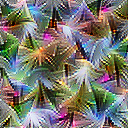

In [8]:
obj = objectives.channel('inception4a', 476) + objectives.channel('inception4a', 465)
list_of_images = render.render_vis(model, obj, show_inline=True)

### Summation

If you want to use the ``sum`` operator, the built-in python method results in an unfortunate nested description. To circumvent
this, you can use the classmethod ``Objectives.sum(iterable_of_objectives)`` instead.

## Parameterizations

We said above that feature visualization is all about optimizing the input image for a given objective function. But in order to that
via the typical autodiff machinery, we need to *parameterize* the image somehow. This way we can then optimize the parameters of that image.

**Question**: Can you come up with at least *two* ways of parameterizing an image?

<details>
<summary><a>Answer</a></summary>

For an initial attempt at feature visualization, we might do gradient descent in the pixel space of a randomly initialized image. Unfortunately, this often creates images comprising high frequency noise, similar to [adversarial images](https://arxiv.org/abs/1312.6199).

Instead, the use of alternative parameterizations can produce more visually intuitive results, by operating in the frequency domain or using compositional pattern producing networks.

Recomended reading: Distill's Feature Visualization article, specifically the section on [Preconditioning and Parameterization](https://distill.pub/2017/feature-visualization/#preconditioning)
</details>

In order to tell ``render_vis`` our parameterization we can use the ``param_f`` keyword. ``param_f`` should be a function without arguments
that returns the image tensor.


The canonical way to do this in Lucent is to call ``lucent.param.image``:

100%|██████████| 512/512 [00:09<00:00, 52.59it/s]



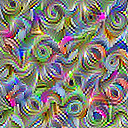

100%|██████████| 512/512 [00:09<00:00, 51.82it/s]



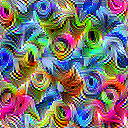

100%|██████████| 512/512 [00:09<00:00, 51.29it/s]



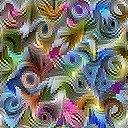

In [9]:
# the width parameter determines the image width -> influences runtime significantly
# this is vanilla RGB-parameterization
param_f = lambda: param.image(w=128, fft=False, decorrelate=False)

# using Fourier basis instead of pixel values
fft_param_f = lambda: param.image(w=128, fft=True, decorrelate=False)

# this is the default setting
fft_decor_param_f = lambda: param.image(w=128, fft=True, decorrelate=True)

# Let's see what the difference in output is:
images = []
for f in [param_f, fft_param_f, fft_decor_param_f]:
    images.append(render.render_vis(model, 'inception4a:476', param_f=f, show_inline=True))

## Batching

Let's say you want to generate many visualizations at once, either for different settings and the same objective or different objectives.

The way Lucent handles this is a bit unintuitive in the beginning.

In essence, you can specify for each objective function which batch dimension it should pay attention to. By default, an objective is applied 
to the full batch of images, but you can also pass a ``batch`` parameter to specify which element of the batch it should be applied to.
(Anything in between one element and all elements is not support at the moment.)

So.. what does this mean for our parameterization function? We have to make sure that the returned images also have a batch dimension. If you 
are using the built-in parameterizations, you can simply pass this as an additional parameter:

In [10]:
batch_size = 3
param_f = lambda: param.image(w=128, batch=batch_size)

Now, let's say we want to optimize three different channels, ``476``, ``477``, and ``478`` of the layer ``inception4a``. We do this by creating the *sum* of
the individual objectives and setting the ``batch`` keyword argument to a different value in [0,1,2] for each of them. This way, each objective will only
be applied to the i-th image, and we can optimize them in parallel.

100%|██████████| 512/512 [00:11<00:00, 43.24it/s]



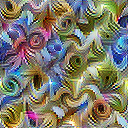
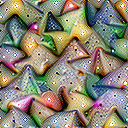
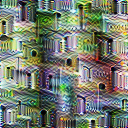

In [11]:
objective = objectives.Objective.sum([objectives.channel('inception4a', ch, batch=i) for i, ch in enumerate([476, 477, 478])])
list_of_images = render.render_vis(model, objective, param_f=param_f, show_inline=True) # list_of_images has length 3

## Transformations
Next to parameterizing the image via the frequency domain, another trick to reduce high-frequency patterns in the visualization is to impose robustness of the result under certain transformations that are applied to the input.

Read more about this in [The Enemy of Feature Visualization](https://distill.pub/2017/feature-visualization/#enemy-of-feature-vis) from Distill's Feature Visualization article.

Those transformations could be paddings, small translations (jitter), rescaling and rotating, just to name a few. 

The default setting for ``render_vis`` is given by

In [12]:
standard_transforms = [
    transform.pad(12, mode="constant", constant_value=0.5),
    transform.jitter(8),
    transform.random_scale([1 + (i - 5) / 50.0 for i in range(11)]),
    transform.random_rotate(list(range(-10, 11)) + 5 * [0]),
    transform.jitter(4),
]

So, actually we already used transformations in all of our examples above. Let's see what our go-to example looks like *without* it by passing an empty iterable:


100%|██████████| 512/512 [00:08<00:00, 60.01it/s]



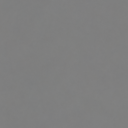

In [14]:
list_of_images = render.render_vis(model, 'inception4a:476', transforms=[], show_inline=True) 

Whoops, that didn't work. Let's see if it is better if we increase the variation in our random initialization (default is ``sd=0.01``).

100%|██████████| 512/512 [00:08<00:00, 59.99it/s]



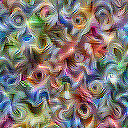

In [15]:
list_of_images = render.render_vis(model, 'inception4a:476', transforms=[], param_f=lambda: param.image(128, sd=0.1), show_inline=True) 

There we go! Sometimes you will get a grey image. We think this is not a bug of the library but rather that the optimizer can't find a locally better image, especially if it does not have the transformation constraint. If this happens to you and you already tried multiple different settings create an issue on GitHub please.

In addition to the transformations above, each image is by default normalized. If you want to override this normalization you can provide a custom ``preprocess_f`` to ``render_vis`` or completely disable it with ``preprocess=False``.

For a full ist of available transformations see the [transformations](https://lucent.readthedocs.io/en/latest/tutorials/transformations.html) page in the docs.


## Conclusion

And that's it for now!

Credits to the folks at [Lucid](https://github.com/tensorflow/lucid) for doing such a great job at creating the original library for Tensorflow and [Lim Swee Kiat](https://github.com/greentfrapp) for the initial work of converting Lucid to Lucent!

Also, a big thanks to [ProGamerGov](https://github.com/ProGamerGov) for converting the original Tensorflow InceptionV1 model to PyTorch!

If you are interested, do check out the `#proj-lucid` channel on the Distill slack ([join link](http://slack.distill.pub))!